In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
json_file_name = 'files-UKF-2017/out_21_all.json'
xfade_index = 0

%matplotlib inline
if json_file_name != 'out.json':    
    print('Warning: reading from '+json_file_name)

In [17]:

data = json.load(open(json_file_name, 'r'))
t1 = data['xfades'][xfade_index]['faders'][0]
t2 = data['xfades'][xfade_index]['faders'][1]


In [18]:
bound_left = data['xfades'][xfade_index]['mix_bounds'][0]
bound_right = data['xfades'][xfade_index]['mix_bounds'][1]
if len(t1) != len(t2):
    raise '1'
duration_xfade = len(t1)
x = np.arange(bound_left,
              bound_right,
              (bound_right-bound_left)/duration_xfade)


if len(x) != len(t1):
    print('Error')
    t1 += [0]
    t2 += [0]
    print(len(x))
    print(len(t1))
    print(len(t2))


In [19]:
def plot_xfade_profile(x, t1, t2, start_t2=None, stop_t1=None):
    fig, ax = plt.subplots(facecolor='white')
    
    ax.plot(x, t1, label='Track 1')
    ax.plot(x, t2, label='Track 2')

    if start_t2 is not None and stop_t1 is not None:
        ax.axvline(x=x[start_t2], color='g', linewidth=.5)
        ax.axvline(x=x[stop_t1], color='r', linewidth=.5)

    ax.legend()
    plt.xlabel('time (s)', color='white')
    plt.ylabel('amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print('Mix bounds: ', data['xfades'][xfade_index]['mix_bounds'])
    print('Track 1: ', data['xfades'][xfade_index]['src_tracks'][0])
    print('Track 2: ', data['xfades'][xfade_index]['src_tracks'][1])

In [14]:
plot_xfade_profile(x, t1, t2)

Mix bounds:  [1713, 1740]
Track 1:  {'path': 'src_tracks/What So Not  Divide and Conquer Noisia remix www.myfreemp3.net.wav', 'bounds': [1647, 1695], 'stretch': 1.0111, 'offset': -1636.0}
Track 2:  {'path': 'src_tracks/The Prototypes feat. Mad Hed City  Levelz www.myfreemp3.net.wav', 'bounds': [1710, 1804], 'stretch': 1.0, 'offset': -1713.0}


In [41]:
t1_ = np.array(t1)

In [42]:
sr = (bound_right-bound_left)/duration_xfade  # seconds/point

In [43]:
def sample_to_time(sample_index):  # This is approximately as x[sample_index].
    # time = sample_index*sr
    # abs_time = bound_left + time
    time = x[sample_index]
    return time

def time_to_sample(time_seconds):
    sample_index = round(1 / sr * time_seconds)
    return sample_index

In [44]:
def trim_marge(t_,marge_seconds):
    marge = time_to_sample(marge_seconds)
    t_[:marge] = None
    t_[len(t_) - marge:] = None
    
def trim_left(t_, marge_sample):
    t_[:marge_sample] = None

In [45]:
marge_seconds = 5
trim_marge(t1_, marge_seconds)

In [46]:
def calc_stop_t1(t1_, from_sample=None):
    stop_t1_bound = .3
    
    if from_sample is not None:
        t1_trimmed = np.copy(t1_)
        trim_left(t1_trimmed, from_sample)
    else:
        t1_trimmed = t1_
    
    pot_stop_t1 = (t1_trimmed < stop_t1_bound).argmax()
    
    average_length_seconds = 5
    avg_after_pot_stop_t1 = np.average(t1_trimmed[pot_stop_t1:pot_stop_t1 + time_to_sample(average_length_seconds)])
    
    steepness_walking_inhibitor = .001
    average_length_seconds_steepness = 1
    avg_after_pot_stop_t1_steepness = np.average(t1_trimmed[pot_stop_t1:pot_stop_t1 + time_to_sample(average_length_seconds_steepness)])
    
    if avg_after_pot_stop_t1 >= stop_t1_bound:
        print(f'INFO: avg_after_pot_stop_t1 >= stop_t1_bound: {avg_after_pot_stop_t1} >= {stop_t1_bound}')
        return calc_stop_t1(t1_trimmed, pot_stop_t1 + 1)
    elif t1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor:
        print(f'INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: {t1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness} > {steepness_walking_inhibitor}')
        return calc_stop_t1(t1_trimmed, pot_stop_t1 + 1)
    else:
        stop_t1 = pot_stop_t1
    return stop_t1

In [47]:
stop_t1 = calc_stop_t1(t1_)

print(sample_to_time(stop_t1))
print(t1_[stop_t1])

INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.11037692207717087 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.07823959984328993 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.07477846134720512 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.06333815407199658 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.060690584351693416 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.03845759582554195 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.028376770204663976 > 0.001
INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: 0.02898181143642789 > 0.001
INFO: 1_trimmed[pot_st

/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/dj-gte/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [48]:
def calc_start_t2(t2_):
    start_t2_bound = .6
    freedom_seconds = 5
    
    pot_start_t2 = (t2_ > start_t2_bound).argmax()
    if (t2_ > start_t2_bound).max() is False:   # if everything is False ; actually does automatically so with
        # "(t2_> start_t2_bound).argmax()"
        start_t2 = 0
    elif pot_start_t2 < time_to_sample(marge_seconds) + time_to_sample(freedom_seconds):
        start_t2 = 0
    else:
        start_t2 = pot_start_t2
    return start_t2

In [49]:
t2_ = np.array(t2)
trim_marge(t2_, marge_seconds)

start_t2 = calc_start_t2(t2_)

print(sample_to_time(start_t2))
print(t1_[start_t2])

175.9648586707342
0.6781149463523579


/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/dj-gte/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/dj-gte/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


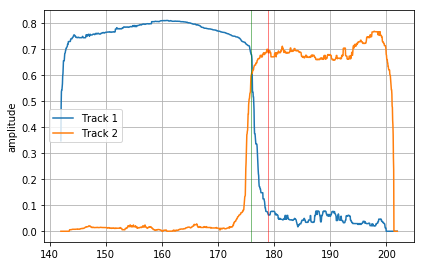

Mix bounds:  [142, 202]
Track 1:  {'path': 'src_tracks/Fox Stevenson - Bruises www.my-free-mp3.net.wav', 'bounds': [1, 170], 'stretch': 1.0, 'offset': -0.136}
Track 2:  {'path': 'src_tracks/Muzzy  Flite - Elevate feat. Miss Trouble www.my-free-mp3.net.wav', 'bounds': [172, 426], 'stretch': 0.994, 'offset': -88.338}


In [50]:
plot_xfade_profile(x, t1, t2, start_t2, stop_t1)